#### Libraries

In [1]:
import copy, time
import pdb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [2]:
from IPython import display
matplotlib.rcParams['figure.figsize'] = [26,8]

#### Generic Utils 

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def check(val, msg):
    '''Checks whether val is nan or inf and prints msg if True'''
    if (val * 0 != 0): print(msg); pdb.set_trace()
        
def to_numpy(t):
    '''PyTorch tensor to numpy array'''
    return t.detach().to('cpu').numpy()

#### Model

In [18]:
# PyTorch
device = torch.device('cpu')

# Data
X = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1).to(device)
Y = - X*X*X*X + 3*X*X + 1

# Plotting range
x_range = torch.arange(-5,5,0.05).reshape(-1,1)

# BBVI hyperparameters
fn_samples = 1000 # function samples after convergence
learning_rate = 1e-4 # learning rate

In [19]:
 class SingleLayerNet(nn.Module):
    def __init__(self, h):
        super(SingleLayerNet, self).__init__()
        self.h = h

        # First 31 are means, last 31 are log_stds
        self.lambdas = nn.Parameter(torch.zeros(62))
        self.lambdas.data[:31].fill_(0.0)
        self.lambdas.data[31:].fill_(0.5)
        
    def forward(self, x, sample):
        
        # Unroll sample weights
        w1 = sample[  :10].reshape(1,10)
        b1 = sample[10:20].reshape(1,10)
        w2 = sample[20:30].reshape(10,1)
        b2 = sample[30:31].reshape( 1,1)
        
        # Forward pass
        x = (x-w1) / b1 # x = x @ w1 + b1 # 
        x = torch.exp(-x*x) # torch.exp(-(x-w1)*(x-w1) / (b1*b1)) 
        x = x @ w2 + b2
        return x 

In [53]:
def BBVI(x, y, model, optimizer, num_samples=50, epochs=int(1e4), seed=None):
    '''Performs black-box variational inference'''
    torch.manual_seed(seed if seed else 10)
    N = 31 # number of weights
    
    # Track ELBO statistics
    elbo_meter = AverageMeter()
    elbo_hist = []
    
    # Prior
    p_dist = Normal(torch.zeros(N), 3.16 * torch.ones(31)) 
    
    for ix_e in range(epochs):
        
        # Set up gradients and control variates
        gradients = torch.zeros(2*N)
        control_f = torch.zeros(2*N,num_samples)
        control_h = torch.zeros(2*N,num_samples)
        
        for ix_s in range(num_samples):
            
            # Distributions
            q_dist = Normal(model.lambdas[:N], F.softplus(model.lambdas[N:])) # torch.exp

            # Sample weights
            sample = q_dist.sample()
                        
            # Likelihood
            y_hat = model.forward(x, sample)
            log_l = Normal(y_hat.squeeze(), 0.1 * torch.ones(6)).log_prob(y.squeeze()).sum()
            elbos = torch.zeros(1)
            
            # Control Variates
            for i in range(N):
                qi_dist = Normal(model.lambdas[i], F.softplus(model.lambdas[i+N]))
                pi_dist = Normal(0, 3.16)
                
                # Log probabilities
                log_pi = pi_dist.log_prob(sample[i]).sum()
                log_qi = qi_dist.log_prob(sample[i]).sum()
                
                # Compute gradients
                optimizer.zero_grad()
                log_qi.backward()
                
                # Update gradients and control variates
                elbo = (log_l + log_pi - log_qi).squeeze()
                gradients[i] += model.lambdas.grad.data[i] * elbo
                gradients[i+N] += model.lambdas.grad.data[i+N] * elbo
                
                # Update control variates
                control_f[  i, ix_s] += model.lambdas.grad.data[  i] * elbo
                control_f[i+N, ix_s] += model.lambdas.grad.data[i+N] * elbo
                control_h[  i, ix_s] += model.lambdas.grad.data[  i]
                control_h[i+N, ix_s] += model.lambdas.grad.data[i+N]
                
                # Track ELBO
                elbos += elbo / N
                
        # Calculate control variates parameters
        a = torch.zeros(2*N)
        for i in range(2*N):
            cov, var = np.cov(to_numpy(control_f[i]), to_numpy(control_h[i]))[[0,1],[1,1]]
            a[i] = cov / var
        gradients = torch.mean(control_f - a.unsqueeze(1) * control_h, dim=1)
        # pdb.set_trace()

        # Update ELBO statistics
        elbo_meter.update(elbos.item())
        elbo_hist.append(elbos.item())
        
        # if ix_e % 50 == 10: 
        #     print(ix_e, elbo_meter.avg)
        #     torch.save(model.lambdas.data.clone(), './weights/hw2.model.lambdas-e{}.data.pth'.format(ix_e))
                
        # Step gradient: 
        optimizer.zero_grad()
        model.lambdas.grad.data = - gradients / num_samples
        optimizer.step()

    return model, elbo_hist

In [75]:
# model = copy.deepcopy(model2) # SingleLayerNet(10)

# model.lambdas.data = current_weights.data
optimizer = torch.optim.SGD([model.lambdas], lr=5e-3)
BBVI(X, Y, model, optimizer, num_samples=25)

10 -254.40605718439275
60 -244.96616351018187
110 -244.137153556755
160 -244.72935476362335
210 -243.75453873042247
260 -243.8083766776483
310 -243.50438898705977
360 -243.53592396575
410 -242.81671558389408
460 -242.40907999233156
510 -242.03338175137216
560 -241.87548632290273
610 -241.77618150976403
660 -241.35028750236384
710 -241.04518657528735
760 -240.7773333836479
810 -240.6455989889387
860 -240.21778130614385
910 -240.04886502413535
960 -239.9373714514503
1010 -239.6914957199323
1060 -239.55601023998494
1110 -239.60575155263328
1160 -239.43743698028118


KeyboardInterrupt: 

In [67]:
# current_weights = model.lambdas.data.clone()
# torch.save(current_weights, './hw2.model.lambdas.data.control_variates.pth')

In [66]:
# model2 = copy.deepcopy(model)

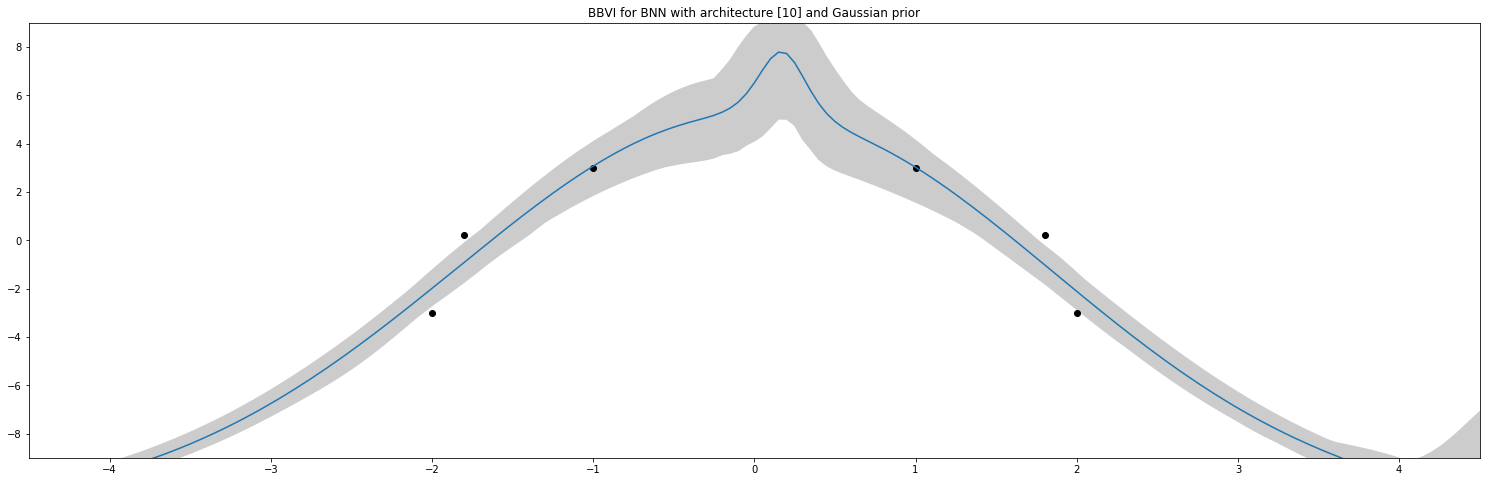

In [76]:
preds = []
for _ in range(5000):
    pred = model(x_range, Normal(model.lambdas[:31], torch.exp(model.lambdas[31:])).sample())
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
bounds = (np.sort(preds, axis=1)[:, 1], np.sort(preds, axis=1)[:,-1])
mean = np.mean(preds, axis=1)

plt.gca().set_title('BBVI for BNN with architecture [10] and Gaussian prior')
plt.gca().fill_between(x_range.reshape(-1), bounds[1], bounds[0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')

plt.plot(to_numpy(x_range), mean)
# plt.scatter(X,Y)
plt.axis([-4.5,4.5,-9,9])
plt.show()

In [89]:
# plt.plot(to_numpy(x_range), to_numpy(model(x_range)))
# plt.scatter(X,Y)

In [ ]:
# # Plot
# fnames = [ ('1_10_1.pth', '[1,10,1]'), ('1_50_1.pth', '[1,50,1]'), ('1_10_10_1.pth', '[1,10,10,1]'), ('1_50_50_1.pth', '[1,50,50,1]') ]

# for i, (fname, name) in enumerate(fnames):
#   samples = torch.load(fname).squeeze().transpose(0,1).detach().cpu().numpy()
#   upper_95 = np.sort(samples, axis=1)[:, 50] 
#   lower_95 = np.sort(samples, axis=1)[:,-50]
  
#   # Plot
#   plt.subplot(2,2,i+1)
#   plt.gca().set_title('BNN with Gaussian prior and network architecture ' + name)
#   plt.gca().fill_between(x_range.reshape(-1), upper_95, lower_95, color="#cccccc")
#   plt.scatter(X, Y, color='black', marker='o')

# plt.show()

In [ ]:
# if False:
#             print('''---------------- id_x {} ---------- 
#                 \n means {} 
#                 grad means {} 
#                 softstds {} 
#                 grad softstds {} 
#                 model.linear.weight.data {} 
#                 model.linear.weight.grad {} 
#                 model.linear.bias.data {} 
#                 model.linear.bias.grad {} 
#                 log_q {} 
#                 log_p {} 
#                 elbo {} '''.format(
#                 ix_e, means, grad_means, softstds, grad_softstds, 
#                 model.linear.weight.data, model.linear.weight.grad, 
#                 model.linear.bias.data, model.linear.bias.grad, log_q, 
#                 log_p, elbo))
# # Plot ELBO statistics
# if ix_e % 10000 == 100:
#     display.clear_output()
#     plt.plot(elbo_history)
#     plt.show()
# - 0.5 * sum((p**2).sum() for p in self.get_sampled_weights()) / self.prior_sigma**2
#         if ix_e % 1000 == 20: 
#             display.clear_output()
#             # ELBO
#             plt.plot(elbo_hist)
#             plt.show()
#             # PLOT
#             y_range = model(x_range, Normal(model.lambdas[:31], torch.exp(model.lambdas[31:])).sample())
#             plt.plot(to_numpy(x_range), to_numpy(y_range))
#             plt.scatter(X,Y)
#             plt.show()
